In [1]:
# RRM nUSP 6516211
# SCC5830 (2022/1)
# Final Project = Morphological characterization of bird droppings using img. proc. techniques

# #Objectives:
# a) total area, area of solid green phase, area of the white on liquid phase;
# b) presence and intensity of red (indicative of blood);
# c) presence of 'dots' from undigested food on the solid phase;
# d) nº of segments of the solid part;

# #Overview of steps:
# * remove background
# * (a) from not bg isolate ref rectangle and count its pixels
# * (a,d) isolate all poop and normalize
#   - count its pixels
#   - spread/texture measurement (diarhea measurement)
#   - overall parameter to directly compare with other images:
#       . hist 95% confidence distances
#       . Haralick or bag of features 95% confid distances
#       . fourier 95% confid distances
# * from all poop isolate green poop:
#   - (a) count its pixels
#   - (d) spread/texture measurement
#   - (b) redish histogram
#   - (c) histogram
# * from all poop isolate white and yellowish histogram

# #Overview of development
# I started developing the code before the lessons of segmentation, so I've ended developing an alternative way to image segmentation.
# This alternative way is poor in performance and will be changed, but I've decided to keep in this partial step for documentation.
# The first step was to explore the image to gain insights on how to segment using the information of color, since the intuitive human perception probably use this info in this case.
# Channels of RGB and HSV spaces were observed.
# Two functions called 'white_limiar' and 'color_limiar' where created to segment the background and the reference card, respectivelly.
# From the image with the segmented reference card of a known size, the conversion factor mm²/pixel was calculated.
# It appears to be reasonable to assume a constant factor for the image because the image is plain (constant focal distance for the entire frame).
# A low pass filter was used to try to segment the reference card, but it was not sucessful
# The green and red histograms were also explored.

In [1]:
import numpy as np
import imageio
import matplotlib as mpl, matplotlib.pyplot as plt
#import matplotlib as mpl
import glob

In [2]:
# from platform import python_version ; print(python_version() == '3.9.2')
# print(np.__version__ == '1.22.3')
# print(imageio.__version__ == '2.16.1')
# import matplotlib ; print(matplotlib.__version__ == '3.5.1')

In [3]:
glob.glob("img-db/*.JPG")

['img-db/IMG_8789.JPG',
 'img-db/IMG_8783.JPG',
 'img-db/IMG_8798.JPG',
 'img-db/IMG_8766-diarrhea.JPG',
 'img-db/IMG_8787.JPG',
 'img-db/IMG_8780.JPG',
 'img-db/IMG_8777.JPG',
 'img-db/IMG_8795.JPG',
 'img-db/IMG_8784.JPG',
 'img-db/IMG_8792.JPG',
 'img-db/IMG_8775.JPG',
 'img-db/IMG_8791.JPG']

In [247]:
# Read input
#img_in = (imageio.imread("sample-imgs/sample-photo1-crop.jpg")).astype(np.uint8)
img_in = (imageio.imread("img-db/IMG_8766-diarrhea.JPG")).astype(np.uint8)
ref_size = 86 * 55 #[mm]

(2848, 4272, 3) 5 226


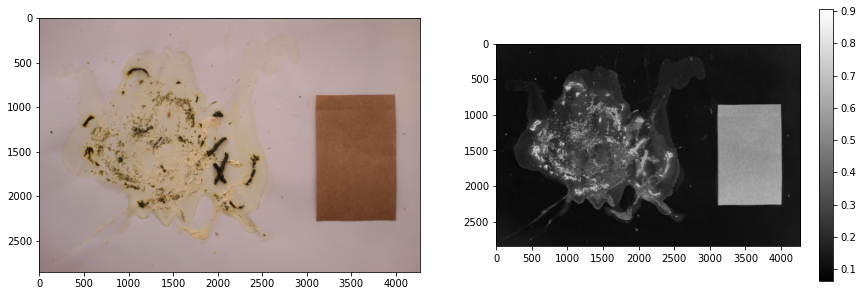

In [248]:
print(img_in.shape, np.min(img_in), np.max(img_in))
plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(img_in)
img_sat = mpl.colors.rgb_to_hsv(img_in)[:,:,1]
plt.subplot(122); plt.imshow(img_sat, cmap='gray'); plt.colorbar() #; plt.title("Saturation")

Text(0.5, 1.0, '0.15')

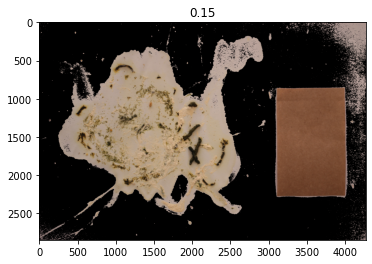

In [254]:
sat_limiar = 0.15
bg = np.where(img_sat < sat_limiar)
img_nobg = np.copy(img_in)
img_nobg[bg] = 0
plt.imshow(img_nobg); plt.title(str(sat_limiar))

In [250]:
# img_hsv = mpl.colors.rgb_to_hsv(img_nobg)
# crgb = (224, 179, 111)
# c = mpl.colors.rgb_to_hsv(crgb)
# threshold = 0.012
# notcard = np.where(np.logical_or(
#                        np.logical_or(img_hsv[:,:,0] < c[0] - threshold,
#                                      img_hsv[:,:,0] > c[0] + threshold),
#                        img_hsv[:,:,1] < c[1] - threshold))
# img_card = np.copy(img_nobg)
# img_card[notcard] = 0
# plt.imshow(img_card)

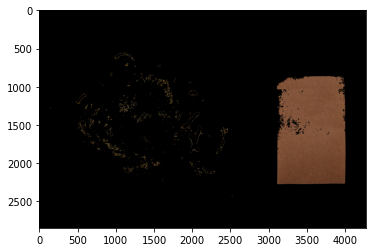

In [277]:
crgb = (113, 71, 47)
thresholdrgb = 25
condition0 = (img_nobg[:,:,0] > crgb[0] + thresholdrgb) | (img_nobg[:,:,0] < crgb[0] - thresholdrgb)
condition1 = (img_nobg[:,:,1] > crgb[1] + thresholdrgb) | (img_nobg[:,:,1] < crgb[1] - thresholdrgb)
condition2 = (img_nobg[:,:,2] > crgb[2] + thresholdrgb) | (img_nobg[:,:,2] < crgb[2] - thresholdrgb)
condition = condition0 | condition1 | condition2
notcard = np.where(condition)
img_card = np.copy(img_nobg)
img_card[notcard] = 0
plt.imshow(img_card)

In [278]:
pixel_to_area = ref_size/np.sum(img_card > 0)

In [279]:
"{:.3} [mm^2/pixel]".format(pixel_to_area)

'0.00126 [mm^2/pixel]'

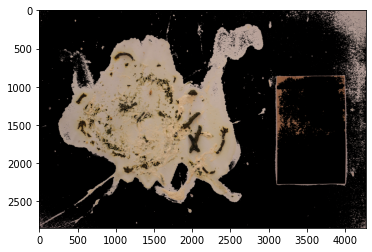

In [280]:
img_pre = np.zeros(img_nobg.shape, dtype=np.uint8)
img_pre[notcard] = np.copy(img_nobg[notcard])
plt.imshow(img_pre)

In [281]:
area_total = pixel_to_area * np.sum(img_pre > 0)
"{:.0f} [mm^2]".format(area_total)

'14604 [mm^2]'

In [282]:
def grayscale_convert(img_in, r=0.299, g=0.587, b=0.114):
    # Default parameter values are for luminance conversion
    img_float = np.array(img_in).astype(float)
    img_lum = (r*img_float[:,:,0] + g*img_float[:,:,1] + b*img_float[:,:,2]).astype(np.uint8)
    
    return img_lum

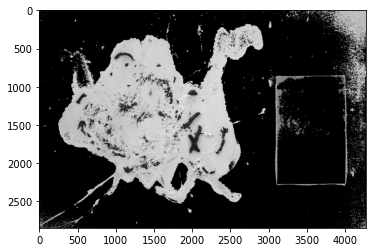

In [283]:
plt.imshow(grayscale_convert(img_pre), cmap="gray")

In [284]:
def haralick(glcm_norm):  # Calculate Haralick descriptors
    im = np.array([glcm_norm.shape[0]*[i] for i in range(glcm_norm.shape[0])])
    jm = np.array([glcm_norm.shape[1]*[j] for j in range(glcm_norm.shape[1])])
    
    auto_cor = np.sum(np.multiply(np.multiply(im, jm),glcm_norm))
    contrast = np.sum(np.multiply((im - jm)**2 , glcm_norm))
    dissim   = np.sum(np.multiply(np.abs(im - jm),glcm_norm))
    energy   = np.sum(glcm_norm**2)
    entropy  = np.sum((-1)*np.multiply(glcm_norm[glcm_norm.nonzero()],np.log(glcm_norm[glcm_norm.nonzero()])))
    homog    = np.sum(np.divide(glcm_norm, (1+(im-jm)**2)))
    inv_dif  = np.sum(np.divide(glcm_norm, (1+np.abs(im-jm))))
    max_prob = np.max(glcm_norm)
    
    return [auto_cor, contrast, dissim, energy, entropy, homog, inv_dif, max_prob]

In [285]:
neighbour = (0, 1)

img_descs = []
# for img_name in img_names[:1]:
    # Part 1 - Morphological Image Processing 
img_gray = grayscale_convert(img_pre)

# Part 2.1 - Feature extraction
# Calculate start and end indexes to avoid undefined neighbours
x_start =  1 if neighbour[0] == -1 else 0
x_end = -1 if neighbour[0] == 1 else img_gray.shape[0]
y_start = 1 if neighbour[1] == -1 else 0
y_end = -1 if neighbour[1] == 1 else img_gray.shape[1]

shifted_img = np.roll(img_gray, (0-neighbour[0],0-neighbour[1]), axis=(0,1))  # Places the neighbour above the ref position
glcm = np.histogram2d(np.ravel(   img_gray[x_start : x_end, y_start : y_end]), \
                      np.ravel(shifted_img[x_start : x_end, y_start : y_end]), \
                      bins=256, range=[[0,256],[0,256]])
glcm_norm = glcm[0]/np.sum(glcm[0])

desc = haralick(glcm_norm)
    # img_descs.append(desc)

print(desc)

[7778.641903752508, 0.0, 0.0, 0.457338910424794, 2.553266142784623, 0.9999999999999998, 0.9999999999999998, 0.6757579534303731]


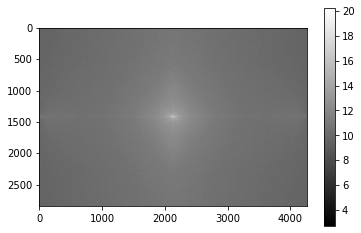

In [286]:
# Fourier transform of input image
spec_freq_0 = np.fft.fft2(img_gray, s=img_gray.shape)
spec_freq_c = np.fft.fftshift(spec_freq_0)
spec_freq_log = np.log(spec_freq_c)
plt.imshow(spec_freq_log.real, cmap="gray")
#plt.imshow(spec_freq_c.real, cmap="gray")
plt.colorbar()

<BarContainer object of 64 artists>

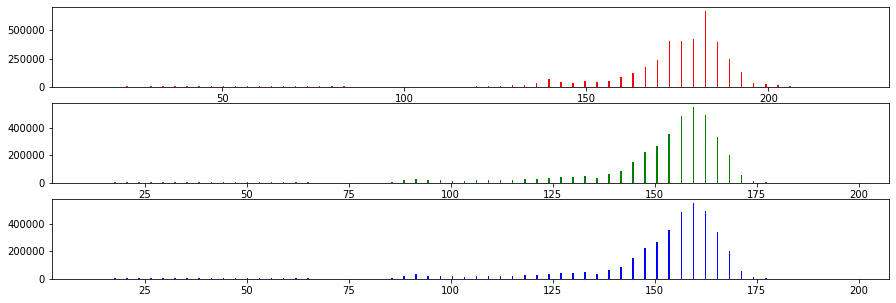

In [287]:
img_poop_r = img_pre[:,:,0]
img_poop_g = img_pre[:,:,1]
img_poop_b = img_pre[:,:,2]

hist_r = np.histogram(img_poop_r[(img_poop_r > 5) & (img_poop_r < 250)], bins=64)
hist_g = np.histogram(img_poop_g[(img_poop_g > 5) & (img_poop_g < 250)], bins=64)
hist_b = np.histogram(img_poop_g[(img_poop_g > 5) & (img_poop_g < 250)], bins=64)


plt.figure(figsize=(15,5))
plt.subplot(311); plt.bar(hist_r[1][:-1]-0.2,hist_r[0], 0.4, color='red')#; plt.xlim([0,255])
plt.subplot(312); plt.bar(hist_g[1][:-1]-0.2,hist_g[0], 0.4, color='green')#; plt.xlim([0,255])
plt.subplot(313); plt.bar(hist_b[1][:-1]-0.2,hist_g[0], 0.4, color='blue')#; plt.xlim([0,255])

Text(0.5, 1.0, '130')

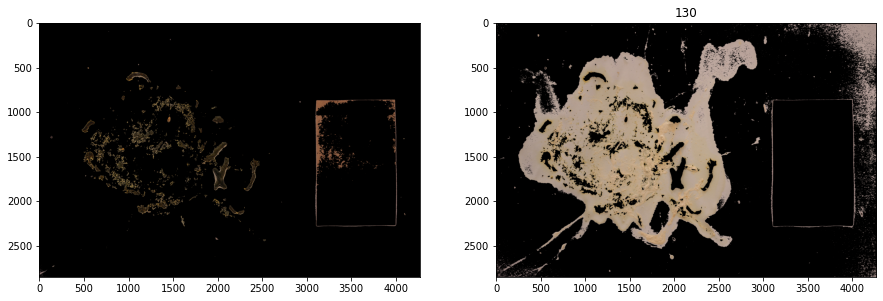

In [293]:
whitelvl = 130
solid_phase = np.where(grayscale_convert(img_pre) < whitelvl)
liquid_phase = np.where(grayscale_convert(img_pre) >= whitelvl)

img_solid = np.zeros(img_pre.shape, dtype=np.uint8)
img_solid[solid_phase] = np.copy(img_pre[solid_phase])

img_liquid = np.zeros(img_pre.shape, dtype=np.uint8)
img_liquid[liquid_phase] = np.copy(img_pre[liquid_phase])

plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(img_solid)
plt.subplot(122); plt.imshow(img_liquid); plt.title(str(whitelvl))